In [4]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

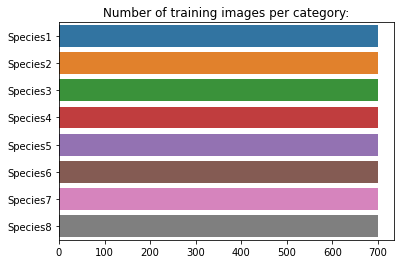

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [9]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py

# get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
#                   v_l=0, v_h=255, pixel_level=False)

# p : the probability that random erasing is performed
# s_l, s_h : minimum / maximum proportion of erased area against input image
# r_1, r_2 : minimum / maximum aspect ratio of erased area
# v_l, v_h : minimum / maximum value for erased area
# pixel_level : pixel-level randomization for erased area


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img


# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='wrap',
                                        #fill_mode='nearest',
                                        preprocessing_function = get_random_eraser(v_l=0, v_h=96), 
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

In [11]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [12]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1.]
Label: 7
Class name: Species8


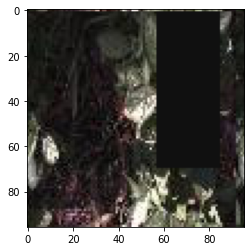

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Vgg19')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

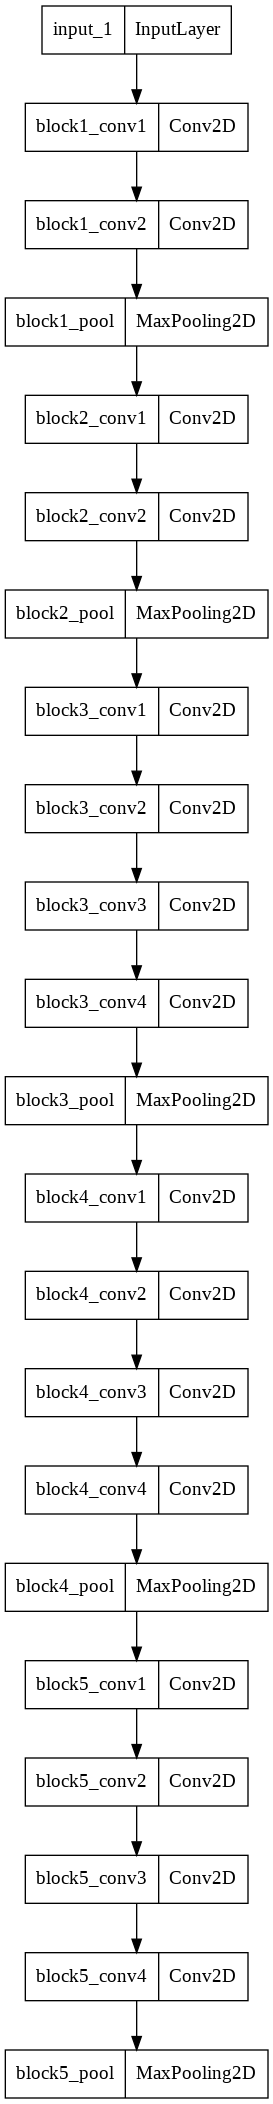

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
106/106 [==============================] - ETA: 0s - loss: 4.3781 - accuracy: 0.3243 - precision: 0.3537 - recall: 0.2327

106/106 [==============================] - 611s 6s/step - loss: 4.3781 - accuracy: 0.3243 - precision: 0.3537 - recall: 0.2327 - val_loss: 1.4307 - val_accuracy: 0.4896 - val_precision: 0.7933 - val_recall: 0.2258
Epoch 2/200
106/106 [==============================] - ETA: 0s - loss: 1.6711 - accuracy: 0.4005 - precision: 0.5698 - recall: 0.2327

106/106 [==============================] - 21s 201ms/step - loss: 1.6711 - accuracy: 0.4005 - precision: 0.5698 - recall: 0.2327 - val_loss: 1.2943 - val_accuracy: 0.5104 - val_precision: 0.6757 - val_recall: 0.2846
Epoch 3/200
106/106 [==============================] - ETA: 0s - loss: 1.5244 - accuracy: 0.4341 - precision: 0.6139 - recall: 0.2578

106/106 [==============================] - 22s 204ms/step - loss: 1.5244 - accuracy: 0.4341 - precision: 0.6139 - recall: 0.2578 - val_loss: 1.1975 - val_accuracy: 0.5560 - val_precision: 0.7445 - val_recall: 0.3871
Epoch 4/200
106/106 [==============================] - ETA: 0s - loss: 1.3894 - accuracy: 0.4891 - precision: 0.6451 - recall: 0.3119

106/106 [==============================] - 21s 200ms/step - loss: 1.3894 - accuracy: 0.4891 - precision: 0.6451 - recall: 0.3119 - val_loss: 1.2285 - val_accuracy: 0.5275 - val_precision: 0.6711 - val_recall: 0.3871
Epoch 5/200
106/106 [==============================] - ETA: 0s - loss: 1.3710 - accuracy: 0.4855 - precision: 0.6505 - recall: 0.3204

106/106 [==============================] - 22s 205ms/step - loss: 1.3710 - accuracy: 0.4855 - precision: 0.6505 - recall: 0.3204 - val_loss: 1.1294 - val_accuracy: 0.5731 - val_precision: 0.6984 - val_recall: 0.4042
Epoch 6/200
106/106 [==============================] - ETA: 0s - loss: 1.3213 - accuracy: 0.5038 - precision: 0.6730 - recall: 0.3349

106/106 [==============================] - 21s 199ms/step - loss: 1.3213 - accuracy: 0.5038 - precision: 0.6730 - recall: 0.3349 - val_loss: 1.0990 - val_accuracy: 0.5446 - val_precision: 0.6808 - val_recall: 0.3966
Epoch 7/200
106/106 [==============================] - ETA: 0s - loss: 1.3129 - accuracy: 0.5059 - precision: 0.6684 - recall: 0.3358

106/106 [==============================] - 22s 205ms/step - loss: 1.3129 - accuracy: 0.5059 - precision: 0.6684 - recall: 0.3358 - val_loss: 1.0776 - val_accuracy: 0.5958 - val_precision: 0.7270 - val_recall: 0.4345
Epoch 8/200
106/106 [==============================] - ETA: 0s - loss: 1.2619 - accuracy: 0.5177 - precision: 0.6738 - recall: 0.3624

106/106 [==============================] - 22s 204ms/step - loss: 1.2619 - accuracy: 0.5177 - precision: 0.6738 - recall: 0.3624 - val_loss: 1.1046 - val_accuracy: 0.5693 - val_precision: 0.7410 - val_recall: 0.3909
Epoch 9/200
106/106 [==============================] - ETA: 0s - loss: 1.2310 - accuracy: 0.5366 - precision: 0.6894 - recall: 0.3730

106/106 [==============================] - 21s 201ms/step - loss: 1.2310 - accuracy: 0.5366 - precision: 0.6894 - recall: 0.3730 - val_loss: 1.0753 - val_accuracy: 0.6034 - val_precision: 0.7284 - val_recall: 0.4478
Epoch 10/200
106/106 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.5505 - precision: 0.7017 - recall: 0.3869

106/106 [==============================] - 22s 204ms/step - loss: 1.2002 - accuracy: 0.5505 - precision: 0.7017 - recall: 0.3869 - val_loss: 1.0754 - val_accuracy: 0.5958 - val_precision: 0.7443 - val_recall: 0.4307
Epoch 11/200
106/106 [==============================] - ETA: 0s - loss: 1.2223 - accuracy: 0.5437 - precision: 0.6940 - recall: 0.3878

106/106 [==============================] - 21s 203ms/step - loss: 1.2223 - accuracy: 0.5437 - precision: 0.6940 - recall: 0.3878 - val_loss: 1.0555 - val_accuracy: 0.6072 - val_precision: 0.7273 - val_recall: 0.4706
Epoch 12/200
106/106 [==============================] - ETA: 0s - loss: 1.1731 - accuracy: 0.5608 - precision: 0.7085 - recall: 0.3949

106/106 [==============================] - 22s 204ms/step - loss: 1.1731 - accuracy: 0.5608 - precision: 0.7085 - recall: 0.3949 - val_loss: 1.0721 - val_accuracy: 0.6110 - val_precision: 0.7259 - val_recall: 0.4421
Epoch 13/200
106/106 [==============================] - ETA: 0s - loss: 1.1231 - accuracy: 0.5777 - precision: 0.7178 - recall: 0.4259

106/106 [==============================] - 21s 201ms/step - loss: 1.1231 - accuracy: 0.5777 - precision: 0.7178 - recall: 0.4259 - val_loss: 1.0813 - val_accuracy: 0.5825 - val_precision: 0.6760 - val_recall: 0.4592
Epoch 14/200
106/106 [==============================] - ETA: 0s - loss: 1.1704 - accuracy: 0.5727 - precision: 0.7017 - recall: 0.4182

106/106 [==============================] - 22s 204ms/step - loss: 1.1704 - accuracy: 0.5727 - precision: 0.7017 - recall: 0.4182 - val_loss: 1.0367 - val_accuracy: 0.6224 - val_precision: 0.7304 - val_recall: 0.4782
Epoch 15/200
106/106 [==============================] - ETA: 0s - loss: 1.1230 - accuracy: 0.5780 - precision: 0.6986 - recall: 0.4265

106/106 [==============================] - 21s 199ms/step - loss: 1.1230 - accuracy: 0.5780 - precision: 0.6986 - recall: 0.4265 - val_loss: 1.0507 - val_accuracy: 0.6015 - val_precision: 0.7188 - val_recall: 0.4706
Epoch 16/200
106/106 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.5800 - precision: 0.7158 - recall: 0.4315

106/106 [==============================] - 21s 202ms/step - loss: 1.1205 - accuracy: 0.5800 - precision: 0.7158 - recall: 0.4315 - val_loss: 1.0570 - val_accuracy: 0.6167 - val_precision: 0.7230 - val_recall: 0.4706
Epoch 17/200
106/106 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.6040 - precision: 0.7224 - recall: 0.4643

106/106 [==============================] - 21s 200ms/step - loss: 1.0823 - accuracy: 0.6040 - precision: 0.7224 - recall: 0.4643 - val_loss: 1.0381 - val_accuracy: 0.6205 - val_precision: 0.7048 - val_recall: 0.5028
Epoch 18/200
106/106 [==============================] - ETA: 0s - loss: 1.0994 - accuracy: 0.5939 - precision: 0.7307 - recall: 0.4575

106/106 [==============================] - 21s 201ms/step - loss: 1.0994 - accuracy: 0.5939 - precision: 0.7307 - recall: 0.4575 - val_loss: 1.0622 - val_accuracy: 0.5958 - val_precision: 0.7135 - val_recall: 0.4820
Epoch 19/200
106/106 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.5859 - precision: 0.7263 - recall: 0.4460

106/106 [==============================] - 21s 200ms/step - loss: 1.0875 - accuracy: 0.5859 - precision: 0.7263 - recall: 0.4460 - val_loss: 1.0265 - val_accuracy: 0.6395 - val_precision: 0.7514 - val_recall: 0.5161
Epoch 20/200
106/106 [==============================] - ETA: 0s - loss: 1.0661 - accuracy: 0.6028 - precision: 0.7375 - recall: 0.4654

106/106 [==============================] - 21s 200ms/step - loss: 1.0661 - accuracy: 0.6028 - precision: 0.7375 - recall: 0.4654 - val_loss: 1.0676 - val_accuracy: 0.6300 - val_precision: 0.7127 - val_recall: 0.4991
Epoch 21/200
106/106 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.5966 - precision: 0.7306 - recall: 0.4598

106/106 [==============================] - 22s 204ms/step - loss: 1.0892 - accuracy: 0.5966 - precision: 0.7306 - recall: 0.4598 - val_loss: 1.0434 - val_accuracy: 0.6129 - val_precision: 0.7198 - val_recall: 0.4972
Epoch 22/200
106/106 [==============================] - ETA: 0s - loss: 1.0611 - accuracy: 0.6125 - precision: 0.7549 - recall: 0.4711

106/106 [==============================] - 21s 197ms/step - loss: 1.0611 - accuracy: 0.6125 - precision: 0.7549 - recall: 0.4711 - val_loss: 1.0304 - val_accuracy: 0.6300 - val_precision: 0.6940 - val_recall: 0.5294
Epoch 23/200
106/106 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.6057 - precision: 0.7286 - recall: 0.4734

106/106 [==============================] - 21s 201ms/step - loss: 1.0537 - accuracy: 0.6057 - precision: 0.7286 - recall: 0.4734 - val_loss: 1.0717 - val_accuracy: 0.6148 - val_precision: 0.7124 - val_recall: 0.5218
Epoch 24/200
106/106 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.6025 - precision: 0.7462 - recall: 0.4722

106/106 [==============================] - 21s 199ms/step - loss: 1.0384 - accuracy: 0.6025 - precision: 0.7462 - recall: 0.4722 - val_loss: 1.1066 - val_accuracy: 0.6110 - val_precision: 0.7201 - val_recall: 0.5028
Epoch 25/200
106/106 [==============================] - ETA: 0s - loss: 1.0636 - accuracy: 0.6143 - precision: 0.7454 - recall: 0.4808

106/106 [==============================] - 21s 201ms/step - loss: 1.0636 - accuracy: 0.6143 - precision: 0.7454 - recall: 0.4808 - val_loss: 1.0838 - val_accuracy: 0.6034 - val_precision: 0.7135 - val_recall: 0.4915
Epoch 26/200
106/106 [==============================] - ETA: 0s - loss: 1.0606 - accuracy: 0.6057 - precision: 0.7389 - recall: 0.4805

106/106 [==============================] - 22s 207ms/step - loss: 1.0606 - accuracy: 0.6057 - precision: 0.7389 - recall: 0.4805 - val_loss: 1.0557 - val_accuracy: 0.6262 - val_precision: 0.7206 - val_recall: 0.5237
Epoch 27/200
106/106 [==============================] - ETA: 0s - loss: 1.0232 - accuracy: 0.6175 - precision: 0.7437 - recall: 0.4885

106/106 [==============================] - 21s 199ms/step - loss: 1.0232 - accuracy: 0.6175 - precision: 0.7437 - recall: 0.4885 - val_loss: 1.0535 - val_accuracy: 0.6243 - val_precision: 0.6990 - val_recall: 0.5332
Epoch 28/200
106/106 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.6229 - precision: 0.7570 - recall: 0.4941

106/106 [==============================] - 21s 201ms/step - loss: 1.0144 - accuracy: 0.6229 - precision: 0.7570 - recall: 0.4941 - val_loss: 1.0204 - val_accuracy: 0.6395 - val_precision: 0.7270 - val_recall: 0.5408
Epoch 29/200
106/106 [==============================] - ETA: 0s - loss: 1.0247 - accuracy: 0.6229 - precision: 0.7566 - recall: 0.4894

106/106 [==============================] - 21s 196ms/step - loss: 1.0247 - accuracy: 0.6229 - precision: 0.7566 - recall: 0.4894 - val_loss: 1.0746 - val_accuracy: 0.6300 - val_precision: 0.7256 - val_recall: 0.5218


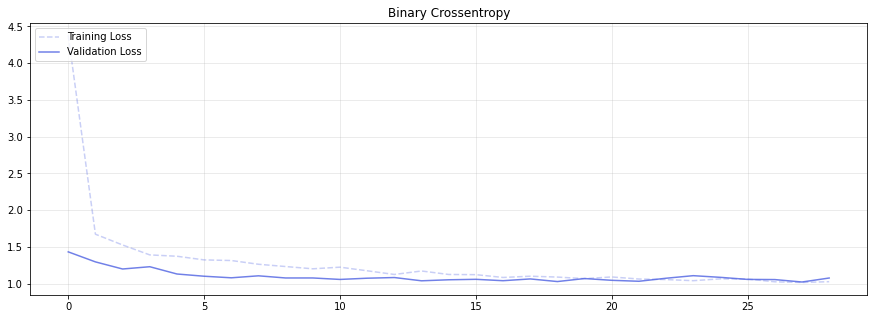

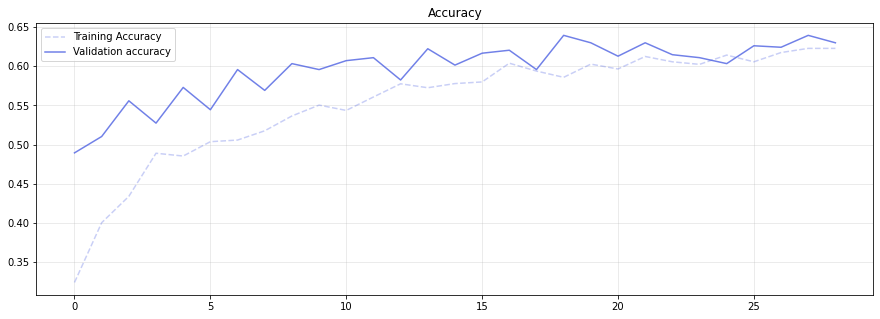

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save('Vgg19/tl_model_cutout')

In [ ]:
tl_model = tfk.models.load_model('Vgg19/tl_model_cutout')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [ ]:
tl_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg19').layers[:13]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
  

In [ ]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
106/106 [==============================] - 18s 151ms/step - loss: 1.5267 - accuracy: 0.4229 - precision_1: 0.6294 - recall_1: 0.2097 - val_loss: 1.1512 - val_accuracy: 0.5560 - val_precision_1: 0.6467 - val_recall_1: 0.3681
Epoch 2/200
106/106 [==============================] - 15s 144ms/step - loss: 1.2735 - accuracy: 0.5115 - precision_1: 0.6733 - recall_1: 0.3018 - val_loss: 1.0370 - val_accuracy: 0.5920 - val_precision_1: 0.7206 - val_recall_1: 0.4649
Epoch 3/200
106/106 [==============================] - 15s 144ms/step - loss: 1.1332 - accuracy: 0.5768 - precision_1: 0.7157 - recall_1: 0.3963 - val_loss: 1.3263 - val_accuracy: 0.5806 - val_precision_1: 0.6536 - val_recall_1: 0.4440
Epoch 4/200
106/106 [==============================] - 15s 143ms/step - loss: 1.0263 - accuracy: 0.6155 - precision_1: 0.7399 - recall_1: 0.4545 - val_loss: 0.9574 - val_accuracy: 0.6717 - val_precision_1: 0.7609 - val_recall_1: 0.5313
Epoch 5/200
106/106 [==============================] - 1

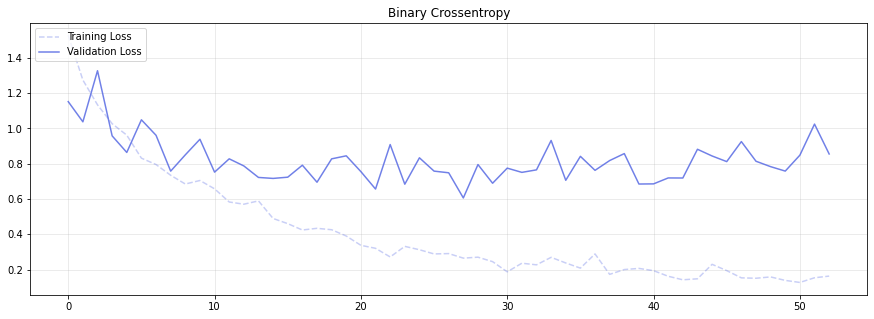

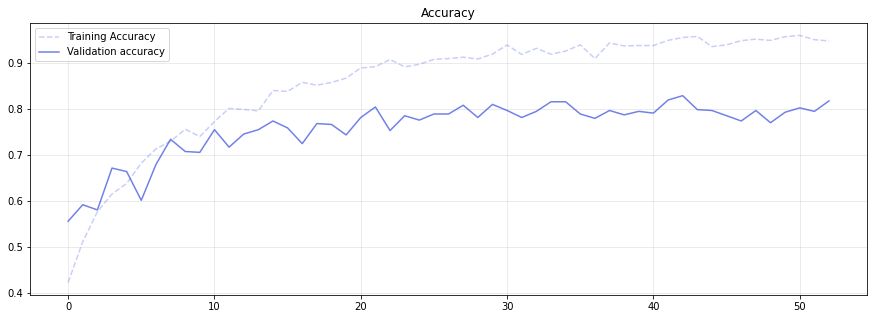

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save('Vgg19/Tuned_cutout_13L')

In [ ]:
# Test the model
tl_model = tfk.models.load_model("Vgg19/Tuned_cutout_13L")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 166s 15s/step - loss: 1.1157 - accuracy: 0.6094 - precision_1: 0.7512 - recall_1: 0.4266

Test metrics
{'loss': 1.1157350540161133, 'accuracy': 0.6094182729721069, 'precision_1': 0.7512195110321045, 'recall_1': 0.42659279704093933}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.6094
Precision: 0.6057
Recall: 0.5758
F1: 0.5653


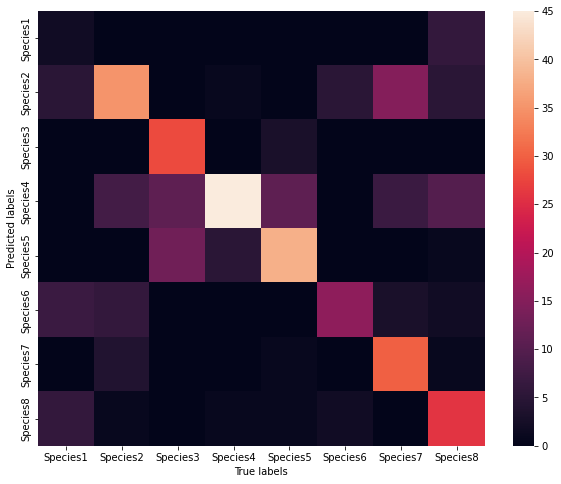

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()